# Juice Examples
This notebook includes:
- Logic Circuits/ Probabilistic Circuits
    - Create a Circuit
    - Structure Properties
    - Circuit Transformations
    - Queries
    - Parameter Learning and Structure Learning
    - Benchmarks and GPU accelerated computing  

In [ ]:
using Revise # TODO remove 

In [2]:
using LogicCircuits
using ProbabilisticCircuits

┌ Info: Precompiling ProbabilisticCircuits [2396afbe-23d7-11ea-1e05-f1aa98e17a44]
└ @ Base loading.jl:1278


## Create a Circuit
1. We can handcraft a Probabilistic Circuit by using `+` and `*` operators easily.

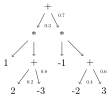

In [11]:
X1, X2, X3 = vars(1:3, ProbCircuit)
pc = 0.3 * (X1[1] * 
             (0.2X2[1] + 0.8X3[2])) + 
     0.7 * (v1[2] *
             (0.4X2[2] + 0.6X3[1]))
plot(pc)

2. Some circuit statistics

In [12]:
println("Logical formula of this circuit: ", tree_formula_string(pc))
println("Some circuit statistics: ")
println("# variables : ", num_variables(pc))
println("# nodes : ", num_nodes(pc))
println("# edges : ", num_edges(pc))
println("# parameters : ", num_parameters(pc))

Logical formula of this circuit: ((1 ⋀ (2 ⋁ -3)) ⋁ (-1 ⋀ (-2 ⋁ 3)))
Some circuit statistics: 
# variables : 3
# nodes : 11
# edges : 10
# parameters : 6


## Structure properties
1. Is the circuit **smooth**?
- A sum node is smooth if its children depend of the same variable sets

In [15]:
c1 = 0.4 * X1[1] + 0.6 * X1[2]
c2 = 0.4 * X1[1] + 0.6 * X2[2]
println("Is ", tree_formula_string(c1), " smooth : ", issmooth(c1))
println("Is ", tree_formula_string(c2), " smooth : ", issmooth(c2))

Is (1 ⋁ -1) smooth : true
Is (1 ⋁ -2) smooth : false


In [16]:
issmooth(pc)

false

2. Is the circuit **deterministic**?
- A sum node is deterministic if the output of only one children is non zero for any input

In [17]:
c1 = X1[1] * X2[1] + X1[1] * X2[2]
c2 = X1[1] * X2[1] + X1[1] * X2[1]
println("Is ", tree_formula_string(c1), " deterministic : ", isdeterministic(c1))
println("Is ", tree_formula_string(c2), " deterministic : ", isdeterministic(c2))

Is ((1 ⋀ 2) ⋁ (1 ⋀ -2)) deterministic : true
Is ((1 ⋀ 2) ⋁ (1 ⋀ 2)) deterministic : false


3. Is the circuit **decomposable**?
- A product node is decomposable if its children depend on disjoint sets of variables

In [223]:
isdecomposable(pc)

true

In [18]:
c1 = X1[1] * X2[1] * X3[1]
c2 = X1[1] * X1[1] * X3[1]
println("Is ", tree_formula_string(c1), " decomposable : ", isdecomposable(c1))
println("Is ", tree_formula_string(c2), " decomposable : ", isdecomposable(c2))

Is (1 ⋀ 2 ⋀ 3) decomposable : true
Is (1 ⋀ 1 ⋀ 3) decomposable : false


4. Is the circuit **structured-decomposable**?
- A product node is structured decomposable if decomposes according to a node in a vtree

Is ((1 ⋀ 2) ⋁ (-1 ⋀ -3)) decomposable : true
Is ((1 ⋀ 2) ⋁ (-1 ⋀ -3)) structured decomposable : false
Is ((1 ⋀ 2) ⋁ (-1 ⋀ -2)) structured decomposable : true


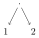

In [19]:
c1 = 0.3 * (X1[1] * X2[1]) + 
     0.7 * (X1[2] * X3[2])
c2 = 0.3 * (X1[1] * X2[1]) + 
     0.7 * (X1[2] * X2[2])
println("Is ", tree_formula_string(c1), " decomposable : ", isdecomposable(c1))
println("Is ", tree_formula_string(c1), " structured decomposable : ", isstruct_decomposable(c1))
println("Is ", tree_formula_string(c2), " structured decomposable : ", isstruct_decomposable(c2))
plot(Vtree(2, :balanced))

## Circuit Transformations

1. **Smooth** a circuit

In [20]:
c1 = 0.4 * X1[1] + 0.6 * X2[2]
c2 = smooth(c1)
println(tree_formula_string(c1), " is smooth? ", issmooth(c1))
println(tree_formula_string(c2), " is smooth? ", issmooth(c2))

(1 ⋁ -2) is smooth? false
((1 ⋀ (2 ⋁ -2)) ⋁ (-2 ⋀ (1 ⋁ -1))) is smooth? true


2. **Forget**

- Given a logical formula $\Delta$ and a variable $X$, forgetting the variable is equivalent to: $ \exists X \Delta $
- PS. it only applies to the Logical Circuits

In [22]:
lv1, lv2 = vars(1:2, LogicCircuit)
c1 = lv1[1] & lv2[2]
c2 = forget(c1, x -> x == 1)
println(tree_formula_string(c1))
println(tree_formula_string(c2))

(1 ⋀ -2)
(true ⋀ -2)


3. **Propagate constants nodes**

In [228]:
c3 = propagate_constants(c2)
println(tree_formula_string(c2))
println(tree_formula_string(c3))

(true ⋀ -2)
(-2)


4. **Condition**
- Given a logical formula $\Delta$ and a variable and its assignment $x$, conditioning on the literal is equivalent to: $ \Delta \cap x$

In [23]:
c1 = (X1[1] + X1[2]) * (X2[1] + X2[2])
println(tree_formula_string(c1))
c2 = condition(c1, Lit(1))
println(tree_formula_string(c2))

((1 ⋁ -1) ⋀ (2 ⋁ -2))
(1 ⋀ (2 ⋁ -2))


5. **Split**
- Given a logical formula $\Delta$ and a variable and a variable $X$, split on the variable is equivalent to: $ (\Delta \cap X=1) \cup (\Delta \cap X=0)$

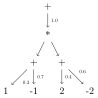

In [28]:
c1 = (+)((.3X1[1] + .7X1[2]) * (.4X2[1] + .6X2[2]))
plot(c1)

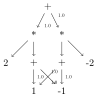

In [31]:
c2, _ = split(c1, (c1, c1.children[1]), Var(2);depth=2)
plot(c2)

6. **Clone**

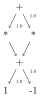

In [32]:
or = X1[1] + X1[2]
and1, and2 = (*)(or), (*)(or)
c1 = and1 + and2
c2 = clone(c1, and1, and2, or)
plot(c1)

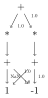

In [232]:
plot(c2)

7. **Merge**

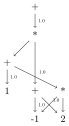

In [34]:
or1 = X1[1] + (X1[2] & X2[1])
or2 = X1[2] + X2[1]
c1 = (+)(or1 * or2)
c2 = merge(c1, or1, or2)
plot(c1)

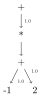

In [35]:
plot(c2)

## Circuit Queries
### Logical queries
1. If the data satisfies circuit logical formula? 

In [36]:
using DataFrames
input = DataFrame(BitArray([1 1 0; 1 0 1]))
println(tree_formula_string(pc))
satisfies(pc, input)

((1 ⋀ (2 ⋁ -3)) ⋁ (-1 ⋀ (-2 ⋁ 3)))


2-element BitArray{1}:
 1
 0

2. Model counting of circuit logical formula

In [37]:
model_count(pc)

8

### Probabilistic queries

- Some helper function:

In [43]:
# You can skip this part. Includes helper functions to make partial observations from arrays of strings
# so its easier to present.

# Make one observation from list of string describing the observation
#
# For example, ["smoker", "male"] sets 
#   1) The mentioned features to the correct values.
#   2) Every feature not mentioned to missing values. 
FEATURES = 36;
function make_one_observation(obs)
    result = missings(Bool, FEATURES)
    for k in obs
        # Smoking
        if lowercase(k) == "smoker"
            result[7:8] .= [0, 1]
        elseif lowercase(k) == "!smoker"
            result[7:8] .= [1, 0]
        # Gender
        elseif lowercase(k) == "male"
            result[13:14] .= [1, 0]
        elseif lowercase(k) == "female"
            result[13:14] .= [0, 1]
        # Region
        elseif lowercase(k) == "southeast"
            result[9:12] .= [0, 0, 1, 0]
        elseif lowercase(k) == "southwest"
            result[9:12] .= [0, 1, 0, 0]
        # Child
        elseif lowercase(k) == "1-child"
            result[1:6] .= [0,1,0,0,0,0]
        end
    end
    result
end;

function make_observations(obs)
    count = size(obs)[1]
    result = missings(Bool, count, FEATURES)
    for i=1:count
        result[i, :] .= make_one_observation(obs[i])
    end
    DataFrame(result)
end;

function flip_coin(d::DataFrame;keep_prob=0.8)
    m = missings(Bool, num_examples(data), num_features(data))
    flag = rand(num_examples(data), num_features(data)) .<= keep_prob
    m[flag] .= Matrix(d)[flag]
    DataFrame(m)
end;

- load data

In [38]:
using CSV
train_x = DataFrame(BitArray(Matrix(CSV.read("insurance/insurance_train_x.csv"))))
println("\"Insurance\" training set has $(num_features(train_x)) variables and $(num_examples(train_x)) samples.")
train_y = CSV.read("insurance/insurance_train_y.csv");

"Insurance" training set has 36 variables and 935 samples.


- load a pretrained probabilistic circuit:

In [39]:
pc = load_prob_circuit(zoo_psdd_file("insurance.psdd"))
println("Probablistic Circuit with $(num_nodes(pc)) nodes and $(num_parameters(pc)) parameters.")

Probablistic Circuit with 27493 nodes and 16272 parameters.


#### EVI: Complete Evidence Query

All features are observed, we want to compute the probability: $P(x)$

In [40]:
log_likelihood_avg(pc, train_x)

-9.711713749299689

#### MAR: Marginal Query (partial evidence)

Now, what happens if we only observe a subset of the features $X^o$? We want to compute: $ P(X^o) = \sum_{x^m} P(X^o X^m) $

**Problem:** Computing above query is usually not tractable as it involves summing over exponential (infinite) possible worlds.

**Good News:** In probabilistic circuits, if the circuit is **smooth** and **decomposable**, we can do this tractably. No need to enumerate all possible worlds.

In [44]:
marg_data = make_observations([["smoker"], 
                       ["female"], 
                       ["female", "smoker"], 
                       ["southeast", "male", "1-child", "smoker"]],
                    )
prob = exp.(marginal(pc, marg_data))
println("Probability of being smoker? ", prob[1])
println("Probability of being female smoker? ", prob[3])
println("Probability of being male smoker with one child living in the southeast? ", prob[4])

Probability of being smoker? 0.18403563
Probability of being female smoker? 0.096237846
Probability of being male smoker with one child living in the southeast? 0.0009639263


#### CON: Conditional Queries

Given some observations $X^o$, we want to compute probabilities conditioned on the observations: $ P(Q \mid X^o) $
if we can do marginals tractably, we can also do conditionals tractably: $ P(Q \mid X^o) = \cfrac{P(Q, X^o)}{P(X^o)} $

In [45]:
println(" P('smoker' | 'female') = $(prob[3]/prob[2])")

 P('smoker' | 'female') = 0.20398751


#### Advanced queries: expected predictions

We have two separate models $p$ and $f$. $p$ is a generative model representing some distributions, and $f$ is a predictive model. We are interested in computing **expected predictions** of $f$ according to the distribution encoded by $g$.

- Appears all the time in machine learning, such as handling missing data
- We can do this tractably!


$ \Large \mathbb{E}_{\mathbf{x}^m\ \sim\ p(\mathbf{x}^m\ \mid\ \mathbf{x}^o )}\left[\ f( \mathbf{x}^o \mathbf{x}^m) \ \right] $

- In above equation $ \mathbf{x}^m $ = missing features, and $ \mathbf{x}^o $ = observed features.

- Expected Prediction useful for:
  - Handling missing values at test time
  - Reasoning about behaviour of predictive models

- load a regression circuit

In [47]:
rc = load_logistic_circuit(zoo_lc_file("insurance.circuit"), 1)
println("Regression Circuit with $(num_nodes(rc)) nodes.")

Regression Circuit with 1076 nodes.


##### Sample Queries
1. How different are the insurance costs between smokers and non smokers?

In [49]:
data = make_observations([["!smoker"], 
                 ["smoker"]])
exps, exp_cache = Expectation(pc, rc, data)
println("Non-Smoker: \$ $(exps[1])");
println("Smoker    : \$ $(exps[2])");
println("Difference: \$ $(exps[2] - exps[1])");

Non-Smoker: $ 8741.747866693713
Smoker    : $ 31355.332794478192
Difference: $ 22613.58492778448


2. Is the predictive model biased by gender?

In [50]:
data = make_observations([["male"],
                 ["female"]])
exps, exp_cache = Expectation(pc, rc, data);
println("Female  : \$ $(exps[2])");
println("Male    : \$ $(exps[1])");
println("Diff    : \$ $(exps[2] - exps[1])");

Female  : $ 14170.126411446157
Male    : $ 13196.551192376319
Diff    : $ 973.5752190698386


3. Expecation and standard devation of few subpopulations

In [51]:
data = make_observations( [["southeast", "male", "1-child", "smoker"], 
                 ["southwest", "male", "1-child", "smoker"]])
exps, exp_cache = Expectation(pc, rc, data);
# Computes the second moment
mom2, mom_cache = Moment(pc, rc, data, 2);
# Computing Standard Deviation
stds = sqrt.( mom2 - exps.^2 );
# Living in South East, Smoker, Male, One child
println("mu: $(round(exps[1])), std = $(round(stds[1]))")

mu: 30975.0, std = 11229.0


## Parameter Learning and Structure learning
### Parameter Learning
1. load data and create a fully factorized circuit

In [53]:
train_x, valid_x, test_x = twenty_datasets("nltcs")
v = Vtree(num_features(train_x), :balanced)
pc = fully_factorized_circuit(StructProbCircuit, v);

2. Maximum likelihood estimate parameters (MLE) given complete data

In [55]:
estimate_parameters(pc, train_x; pseudocount=1.0);
println("Traing set log-likelihood is ", log_likelihood_avg(pc, train_x))

Traing set log-likelihood is -9.27033051835188


### Structure learn
#### Initializations
- Initialized from a Chow-Liu Tree

In [56]:
pc, vtree = learn_chow_liu_tree_circuit(train_x)
println("Initial circuits has $(num_nodes(pc)) nodes, $(num_parameters(pc)) parameters.")
println("Traing set log-likelihood is ", log_likelihood_avg(pc, train_x))

Initial circuits has 121 nodes, 74 parameters.
Traing set log-likelihood is -6.7600561877106955


#### Strcuture update
- Perform greedy search based on some buid-in heuristics, you can also use customized strategies by writing the callback function

In [58]:
loss(circuit) = ProbabilisticCircuits.heuristic_loss(circuit, train_x)
pc = struct_learn(pc; 
    primitives=[split_step], 
    kwargs=Dict(split_step=>(loss=loss,)),
    maxiter=10)
estimate_parameters(pc, train_x; pseudocount=1.0)
println("Circuits has $(num_nodes(pc)) nodes, $(num_parameters(pc)) parameters.")
println("Traing set log-likelihood is ", log_likelihood_avg(pc, train_x))

Circuits has 305 nodes, 196 parameters.
Traing set log-likelihood is -6.383045029183077


## Benchmarks and GPU accelerated computing 
#### Load circuit and data

In [113]:
using BenchmarkTools
pc = zoo_psdd("plants.psdd")
println("Load a circuit with $(num_nodes(pc)) nodes and $(num_parameters(pc)) parameters.")
data, _, _ = twenty_datasets("plants")
println("Load a data with $(num_features(data)) features and $(num_examples(data)) examples.")

Load a circuit with 153021 nodes and 91380 parameters.
Load a data with 69 features and 17412 examples.


#### Move data to GPU

In [134]:
@btime gpu_data = to_gpu(data);

  534.548 μs (928 allocations: 36.72 KiB)


#### If the data satisty logical constrains ?
- CPU computation

In [109]:
@btime satisfies(pc, data);

  242.001 ms (926339 allocations: 189.61 MiB)


- GPU computation

In [115]:
@btime satisfies(pc, gpu_data);

  102.614 ms (930755 allocations: 57.47 MiB)


#### EVI queries
- CPU computation

In [116]:
@btime EVI(pc, data);

  529.217 ms (926493 allocations: 328.13 MiB)


- GPU computation

In [117]:
@btime EVI(pc, gpu_data);

  95.877 ms (933369 allocations: 63.70 MiB)


#### MAR queries
- CPU computation

In [126]:
data_miss = flip_coin(data)
@btime MAR(pc, data_miss);

  10.357 s (5664922 allocations: 4.30 GiB)


- GPU computation

In [125]:
gpu_data_miss = to_gpu(data_miss)
@btime MAR(pc, gpu_data_miss);

  661.239 ms (5670545 allocations: 190.59 MiB)


#### Maximum likelihood estimate parameters (MLE) given complete data
- CPU computation

In [131]:
@btime estimate_parameters(pc, data;pseudocount=1.0);

  575.903 ms (1215948 allocations: 337.26 MiB)


- GPU computation

In [132]:
@btime estimate_parameters(pc, gpu_data;pseudocount=1.0);

  152.761 ms (1222243 allocations: 73.24 MiB)


#### Expectation maximization estimate parameters (EM) given data with missing values
- CPU computation 

In [136]:
# @time estimate_parameters_em(pc, data_miss;pseudocount=1.0)

- GPU computation

In [137]:
# TODO @btime estimate_parameters_em(pc, gpu_data_miss;pseudocount=1.0)